# Sample MERRA-2 at an MPL Site
This is an example showing how to use GMAOpyobs utilities to sample MERRA-2 at an MPL site.

This assumes that you have cloned the GMAOpyobs Github repository, installed it in a directory called \\$AERODIR, and have added the following directory to your $PYTHONPATh environment variable:
\\$AERODIR/install/lib/Python

It also assumes you have a grads style control file for the MERRA-2 files. An example of such a file is in this directory called inst3_3d_aer_Nv, and it points to files in a directory called MERRA2_all also in this directory.

The inst3_3d_aer_Nv MERRA-2 Collection contains 3-D aerosol mass mixing ratios on the native model vertical levels.
You will additinally need the inst3_3d_asm_Nv collection that has the temperature vertical profile to calculate total attenuated backscatter.

The MPL Level1.5 file used in this example can be found at https://portal.nccs.nasa.gov/datashare/iesa/campaigns/ASIA-AQ/ipynb_examples/

The GEOS aerosol optics files can be found at https://portal.nccs.nasa.gov/datashare/iesa/aerosol/ExtData/


## MPL Sampling

In [17]:
# You only need to do this first import if you're using the discover jupyterhub
# if you are, make sure to use the latest GEOSpyd kernel
# Add a kernel to your Jupyterhub by executing the following on discover:
# python3 -m ipykernel install --user --name GEOSpyD-24.11.3-3.13 --display-name "GEOSpyD 24.11.3 3.13"
# restart Jupyterhub and the new kernel should be available

import sys
sys.path.append('/gpfsm/dnb34/pcastell/workspace/GMAOpyobs_update_notebooks/GMAOpyobs/install/lib/Python')

from pyobs.sampler import STATION
from pyobs.mpl import MPL_L15
from datetime import datetime

In [36]:
## Read the MPL file
mplAERFile = 'MPLNET_V3_L15_AER_20230605_MPL44258_GSFC.nc4'
mplNRBFile = 'MPLNET_V3_L15_NRB_20230605_MPL44258_GSFC.nc4'

variables = ['latitude', 'longitude', 'time', 'surface_altitude', 'altitude', 'backscatter', 'c']
mplAERdata = MPL_L15.read_file(mplAERFile,variables=variables,verb=0)
variables = ['time','altitude','nrb']
mplNRBdata = MPL_L15.read_file(mplNRBFile,variables=variables,verb=0)

# get the mpl obs time and location
time = mplAERdata.tyme
time_range = [time.min(),time.max()]
lon, lat = mplAERdata.longitude[0], mplAERdata.latitude[0]

In [19]:
## Create a station object with aerosol data
m2data = ['inst3_3d_aer_Nv','inst3_3d_asm_Nv']  # MERRA-2 collection ctrl files
stn = STATION(['GSFC'],[lon],[lat],m2data,time_range=time_range,times=time,verbose=True)

In [20]:
## Sample the MERRA-2 dataset at the station, and return an xarray dataset
# on Jupyterhub this will take a minute - stand up, get a cup of coffee
# on the command line, this takes ~7 seconds

# Variables I want to read
du = ['DU001','DU002','DU003','DU004','DU005']
ss = ['SS001','SS002','SS003','SS004','SS005']
bc = ['BCPHILIC','BCPHOBIC']
oc = ['OCPHILIC','OCPHOBIC']
su = ['SO4']
met = ['AIRDENS','DELP','PS','RH','T']
Variables = met + du + ss + bc + oc + su

stn_ds = stn.sample(Variables=Variables).compute()

[ ] sampling  AIRDENS
[ ] sampling  DELP
[ ] sampling  PS
[ ] sampling  RH
[ ] sampling  T
[ ] sampling  DU001
[ ] sampling  DU002
[ ] sampling  DU003
[ ] sampling  DU004
[ ] sampling  DU005
[ ] sampling  SS001
[ ] sampling  SS002
[ ] sampling  SS003
[ ] sampling  SS004
[ ] sampling  SS005
[ ] sampling  BCPHILIC
[ ] sampling  BCPHOBIC
[ ] sampling  OCPHILIC
[ ] sampling  OCPHOBIC
[ ] sampling  SO4


In [21]:
## optional: you can write sampled data to a netcdf file
outFile = 'm2_mpl_sampled.nc4'
comp = dict(zlib=True)
encoding = {var: comp for var in stn_ds.data_vars}
stn_ds.to_netcdf(outFile,engine='netcdf4',encoding=encoding)

# Calculate Aerosol Optical Properties on the Sampled Dataset
Now that we have the 3-D aerosol mass mixing ratios, we would like to convert this to 3-D total and speciated aerosol optical properties.
You will need the aerosol optics tables, and a yaml file describing which files to use.
An example yaml file called m2_pm25.yaml can be found in the  directory GMAOpyobs/src/config. 
It points to optics files located in the directory ExtData.


In [22]:
from pyobs.aop import G2GAOP

# set up some filenames
# this configuration file can be found in src/config
config = 'm2_pm25.yaml'

In [23]:
## Read the sampled aerosol profile data and optical tables
optics = G2GAOP(stn_ds,config=config)

In [24]:
# caluclate profiles of total:
#        EXT:     aerosol extinction profile
#        SCA:     aerosol scattering profile
#        BSC:     aerosol backscatter profile
#        DEPOL:   aerosol depolarization ratio
#        ABACKTOA: total attenuated backscatter from the TOA
#        ABACKSFC: total attenuated backscatter from the surface
# at 532 nm
aop532 = optics.getAOPext(wavelength=532)

In [25]:
# optional: you can write this to a netcdf file
outFile = 'm2_mpl_ext532.nc4'
encoding = {var: comp for var in aop532.data_vars}
aop532.to_netcdf(outFile,engine='netcdf4',encoding=encoding)

## Compare MERRA-2 532 nm Total Attenuated Backscatter Profile to MPL Observations

In [45]:
## Plot MPL 532 nm total attenuated backscatter
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pyobs.sampler import addVertCoord
from scipy.interpolate import interp1d

# Get the MPL vertical coordinate
# convert from altitude above sea level to altitude above surface
ntime, nlev = mplAERdata.altitude.shape 
mplAERdata.z = np.repeat(mplAERdata.surface_altitude.reshape(ntime,1),nlev,axis=1) + mplAERdata.altitude

# Get time coordinate
time = mplAERdata.tyme
time = np.repeat(time.reshape(ntime,1),nlev,axis=1)

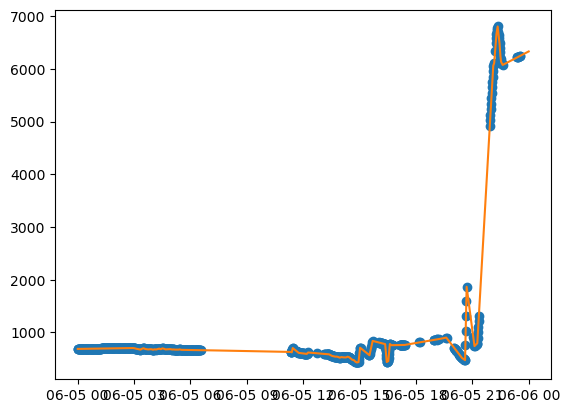

In [46]:
## Linearly interpolate C from aerosol retrievals to fill in missing values
C = mplAERdata.c.squeeze()
notmissing = ~np.isnan(C)
f = interp1d(mplAERdata.time[notmissing], C[notmissing],fill_value="extrapolate")
Cinterp = f(np.array(mplAERdata.time))

# sanity check
plt.plot(mplAERdata.tyme,C,'o')
plt.plot(mplAERdata.tyme,Cinterp)

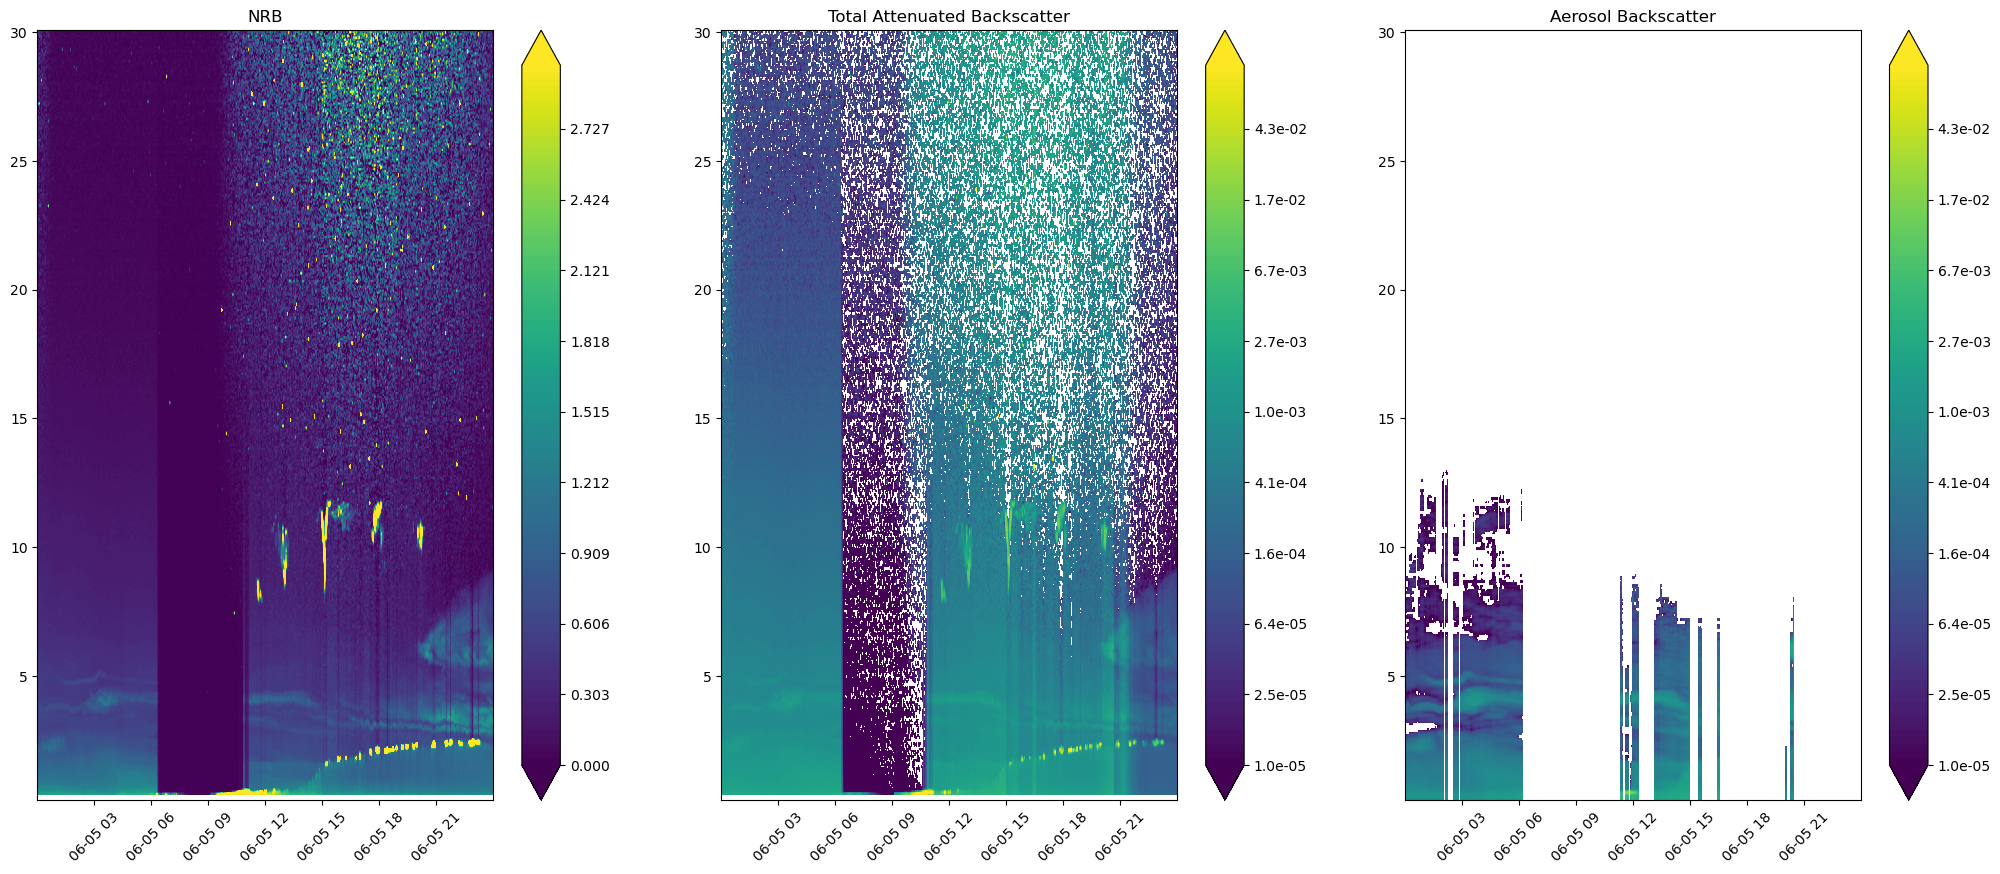

In [47]:
## Use C to convert NRB to attenuated backscatter
Cinterp_z = np.repeat(Cinterp.reshape(ntime,1),nlev,axis=1)
aback = mplNRBdata.nrb.squeeze()/Cinterp_z

# Plotting part
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(25, 10))
im = ax[0].contourf(time,mplAERdata.z,mplNRBdata.nrb.squeeze(),np.linspace(0,3,100),extend='both')
plt.colorbar(im,ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('NRB')

# mask values <=0 for log-scale plotting
aback[np.where(aback<=0)] = np.nan
im = ax[1].contourf(time,mplAERdata.z,aback,np.logspace(-5, -1, 100, endpoint=True),extend='both',norm=LogNorm())
plt.colorbar(im,ax=ax[1], format='%.1e')
ax[1].set_title('Total Attenuated Backscatter')

# mask values <=0 for log-scale plotting
backscat = mplAERdata.backscatter.squeeze()
backscat[np.where(backscat<=0)] = np.nan
im = ax[2].contourf(time,mplAERdata.z,backscat,np.logspace(-5, -1, 100, endpoint=True),extend='both',norm=LogNorm())
plt.colorbar(im,ax=ax[2], format='%.1e')
ax[2].set_title('Aerosol Backscatter')


ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
ax[2].tick_params(axis='x', rotation=45)

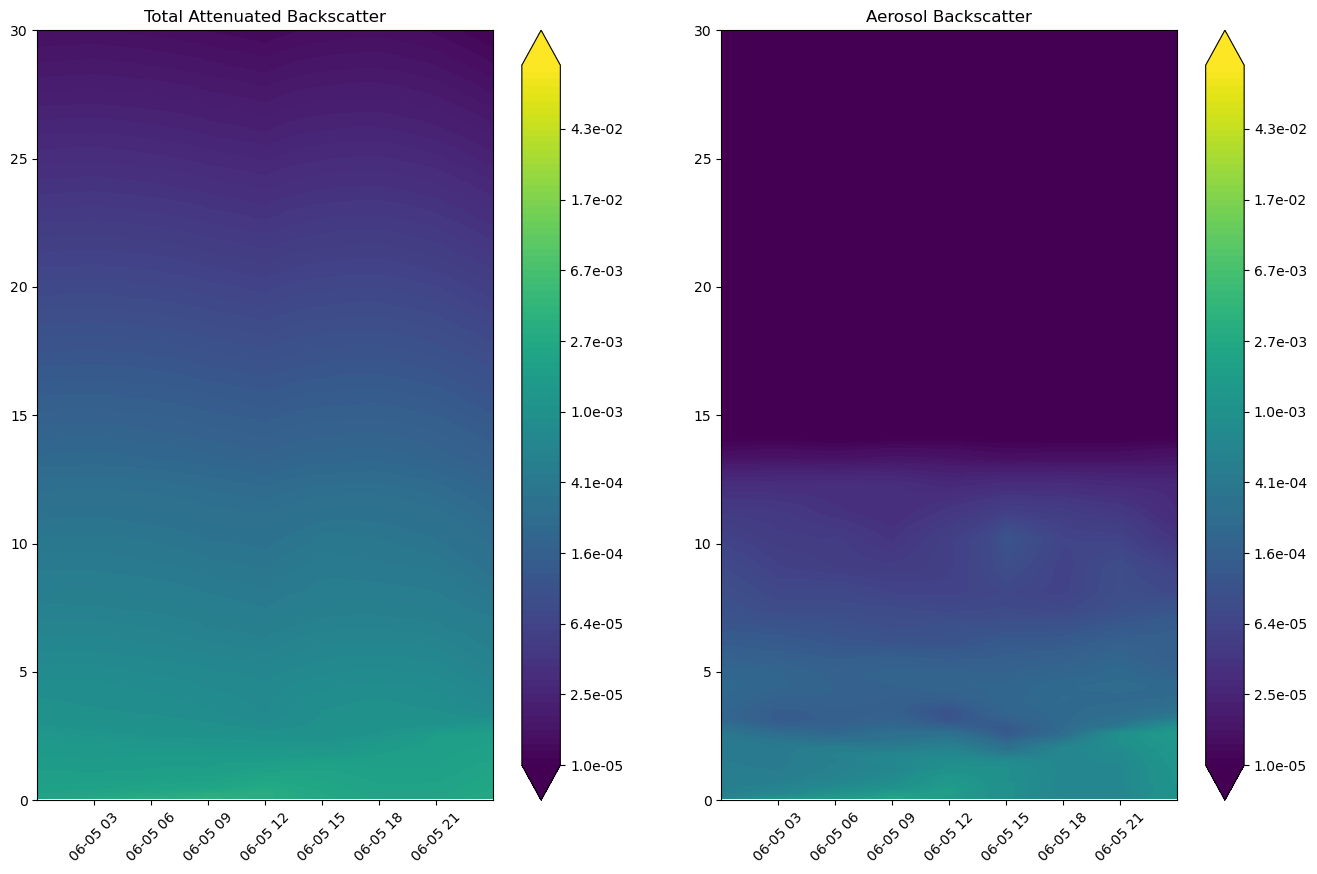

In [43]:
# Plot MERRA-2 532 nm total attenuated backscatter

# Get MERRA-2 vertical coordinate
aop532.pipe(addVertCoord)

# Get time coordinate
time = aop532.time.values
ntime = aop532.sizes['time']
nlev = aop532.sizes['lev']
time = np.repeat(time.reshape(ntime,1),nlev,axis=1)

# plotting part
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(25, 10))
im = ax[0].contourf(time,aop532.Z.squeeze(),aop532.ABACKSFC.squeeze(),np.logspace(-5, -1, 100, endpoint=True),extend='both',norm=LogNorm())
plt.colorbar(im,ax=ax[0], format='%.1e')
ax[0].set_ylim([0,30])
ax[0].set_title('Total Attenuated Backscatter')

im = ax[1].contourf(time,aop532.Z.squeeze(),aop532.BSC.squeeze(),np.logspace(-5, -1, 100, endpoint=True),extend='both',norm=LogNorm())
plt.colorbar(im,ax=ax[1], format='%.1e')
ax[1].set_ylim([0,30])
ax[1].set_title('Aerosol Backscatter')

ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
ax[2].set_visible(False)